# Исследование сервиса самокатов GoFast

Исследование проводится на основе данных о пользователях, их поездках и подписках сервиса самокатов GoFast для проверки ряда гипотез. Данные были выгружены автоматически из базы данных сервиса и хранятся в 3 отдельных датасетах, данные об имени и возрасте изначально заполнялись пользователями.

**Цель исследования:**
Для увеличения числа пользователей с подпиской необходимо 

1. Определить, какая группа пользователей в зависимости от подписки тратит больше времени на поездки.
2. Выявить, превышает ли среднее расстояние поездок пользователей с подпиской оптимальное с точки зрения износа самоката расстояние.
3. Установить, превышает ли помесячная выручка от пользователей с подпиской выручку от пользователей без подписки. 

**Ход исследования:**
Данные загружаются из следующих трех датасетов: ```/datasets/users_go.csv```, ```/datasets/rides_go.csv```, ```/datasets/subscriptions_go.csv```. Поскольку качество данных неизвестно, сначала необходимо их изучить. В случае обнаружения ошибок и их влияния на исследование на этапе предобработки данных будет рассмотрены варианты исправления ошибок без искажения конечных результатов. Исследовательский анализ поможет оценить выборку данных, затем таблицы будут объединены и будут созданы необходимые для проверки гипотез столбцы. 

Исследование пройдет в 7 этапов:
- [Обзор данных](#one)
- [Предобработка данных](#tw)
- [Исследовательский анализ данных](#thr)
- [Подготовка данных к анализу](#fr) объединение таблиц, создание дополнительных столбцов из агрегированных данных
- [Подсчет выручки](#fi)
- [Проверка гипотез](#six)
- [Вывод](#sev)

<a id='one'></a>
## Обзор данных

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
import numpy as np

### Загрузка данных

In [2]:
try:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

### Вывод общей информации

In [3]:
#выведем первые строки датасета с информацией о пользователях
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
#выведем первые строки датасета с информацией о поездках
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [5]:
#выведем информацию о подписках
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
#изучим информацию о пользователях
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
#изучим информацию о поездках
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


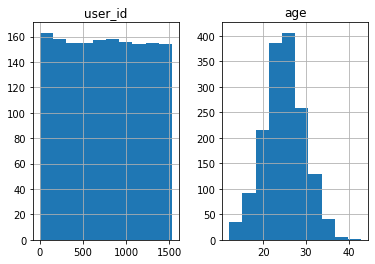

In [8]:
#выведем распределение числовых значений в датасете для проверки на наличие аномалий
users.hist();

In [9]:
#изучим число уникальных значений
users.user_id.sort_values()

0          1
1          2
2          3
3          4
4          5
        ... 
1529    1530
1530    1531
1531    1532
1532    1533
1533    1534
Name: user_id, Length: 1565, dtype: int64

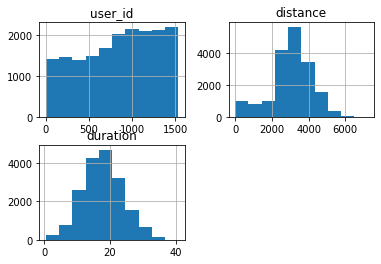

In [10]:
#выведем распределение числовых значений в датасете для проверки на наличие аномалий
rides.hist();

**Вывод:**
- В датасете suscripions хранится общая информация о подписках, данные в ней соответствуют информации указанной в описании проекта.
- Названия столбцов не требуют исправления.
- В датасете о пользователях и поездках не ожидается наличие пропусков, но возможно наличие дубликатов, поскольку число уникальных значений в столбце с уникальным идентификатором пользователя отличается от количества строк с данными о пользователях примерно на 30 значений.
- Числовые значения распределены нормально, на данном этапе явно аномальные значния не выделены, но стоит проверить данные в датасете о поездах - соотношение дистанции и времени поездки. Также необходимо проверить значения близкие к 0.
- Необходимо изменить тип данных в столбце с датой совершения поездки для дальнейшей работы с ее компонентами.

<a id='tw'></a>
## Предобработка данных

In [11]:
#проверим наличие пропусков 
print(users.isna().sum())
rides.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


user_id     0
distance    0
duration    0
date        0
dtype: int64

In [12]:
#проверим наличие дубликатов
users.duplicated().sum()

31

In [13]:
rides.duplicated().sum()

0

In [14]:
#удалим дубликаты с заменой индекса
users = users.drop_duplicates().reset_index(drop=True)

In [15]:
#проверим наличие неявных дубликатов в столбце с названиями города
users.city.sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

In [16]:
#изменим тип данных в столбце с датой
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [17]:
#создадим столбец с месяцем
rides['month'] = rides['date'].dt.month
rides['month']

0         1
1         1
2         4
3         8
4         8
         ..
18063    11
18064    11
18065    11
18066    11
18067    12
Name: month, Length: 18068, dtype: int64

**Вывод:**
- В столбце с датой поздки был изменен тип данных на datetime, а также создан отдельный столбц с обозначением месяца для дальнейшего анализа данных
- Изначальные данные были без большого числа ошибок - были удалены явные дубли, пропусков нет, неявных дублей из-за написания городов также нет. 

<a id='thr'></a>
## Исследовательский анализ данных

Рассмотрим подробнее данные о:
1. частоте встречаемости городов
2. соотношении пользователей с подпиской и без подписки
3. возрасте пользователей
3. расстоянии, которое пользователь преодолел за одну поездку
3. продолжительности поездок

### Город

In [18]:
#выведем количество пользователей по городам
users.city.value_counts().sort_values()

Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: city, dtype: int64

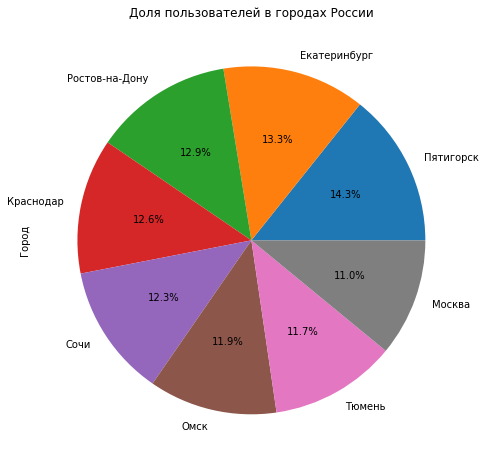

In [19]:
#визуализируем данные в процентных долях
users['city'].value_counts(1).plot(kind='pie', figsize=(15, 8), autopct='%1.1f%%', title='Доля пользователей в городах России', label='Город');

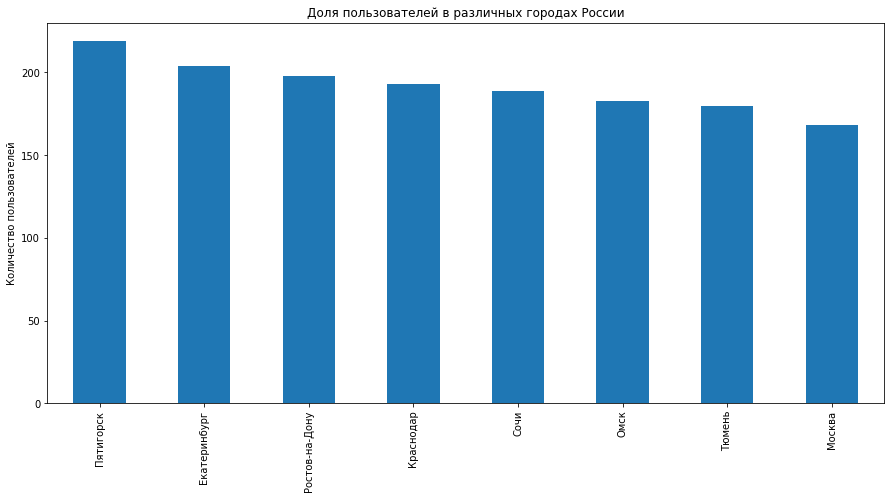

In [20]:
users['city'].value_counts().plot(kind='bar', figsize=(15, 7), title='Доля пользователей в различных городах России')
plt.ylabel('Количество пользователей')
plt.show()

- Доля пользователей из различнных городов в среднем одинаковая, с максимальной разницей в 3.3%. 
- Больше всего пользователей сервиса в южных городах России, что может объясняться более частым пользованием самокатов из-за хорошего климата: большего числа теплых дней и дней без осадков.
- В Москве может быть меньше клиентов из-за большего числа альтернатив в столице - развитая сеть транспорта, которая позволяет легко добраться до нужного места и без самоката, а также большее число конкурентов.
- На число и долю пользователей также может влиять благоустроенность города: есть ли достоточно хороших тротуаров и дорог для перемещения по городу на самокате, а также удобство и возможность преодолять марштрут на другом транспорте.

### Подписка

In [21]:
#выведем количество пользователей с подпиской и без
users.subscription_type.value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

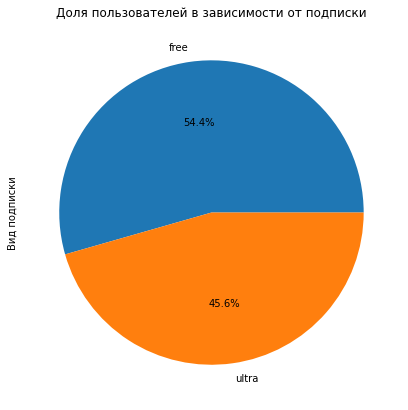

In [22]:
#визуализируем данные
users.subscription_type.value_counts(1).plot(kind='pie', figsize=(13, 7), autopct='%1.1f%%', title='Доля пользователей в зависимости от подписки', label='Вид подписки');

In [23]:
#выведем распределение подписок по городам
city_sus = users.pivot_table(index='city', columns='subscription_type', values='name', aggfunc='count')
city_sus 

subscription_type,free,ultra
city,,
Екатеринбург,112,92
Краснодар,112,81
Москва,84,84
Омск,92,91
Пятигорск,125,94
Ростов-на-Дону,109,89
Сочи,103,86
Тюмень,98,82


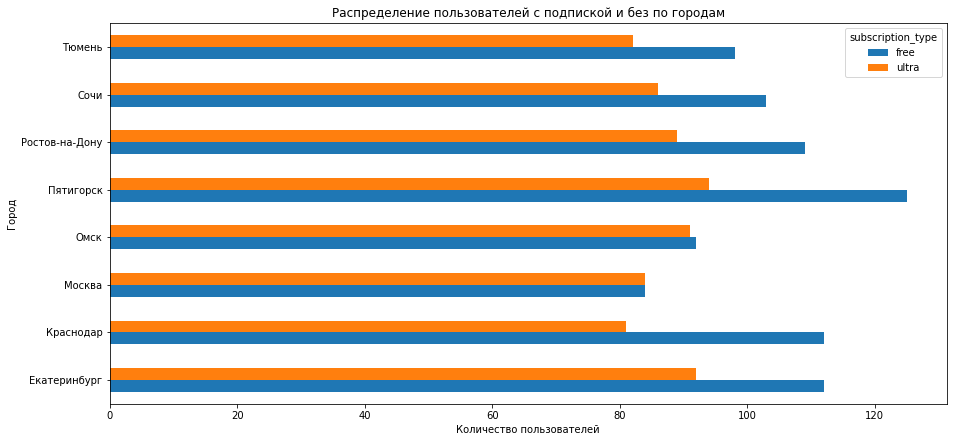

In [24]:
city_sus.plot(kind='barh', figsize=(15, 7), title='Распределение пользователей с подпиской и без по городам')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.show()

- Большее число пользователей предпочитает бесплатный тип подписки, однако, разница между распределением пользователей по двум видам подписки составляет около 10%. Это может объясняться частотой пользования самокатами: люди, которые часто пользуются сервисом находят более выгодной платную подписку, а пользователям, которым необходимы самокаты лишь изредка выгоднее оплачивать по тарифу бесплатной подписки. Проверим данную гипотезу ниже.
- В соответствии с распределением по городам в Москве и Омске равное или незначительное отличие в числе пользователей двух подписок, наибольшая разница заметна в южных городах: Пятигорске и Краснодаре, где пользователи чаще предпочитают сервис с бесплатной подпиской. 

### Возраст

In [25]:
#выведем значения возрастов пользователей
users.age.sort_values().unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43])

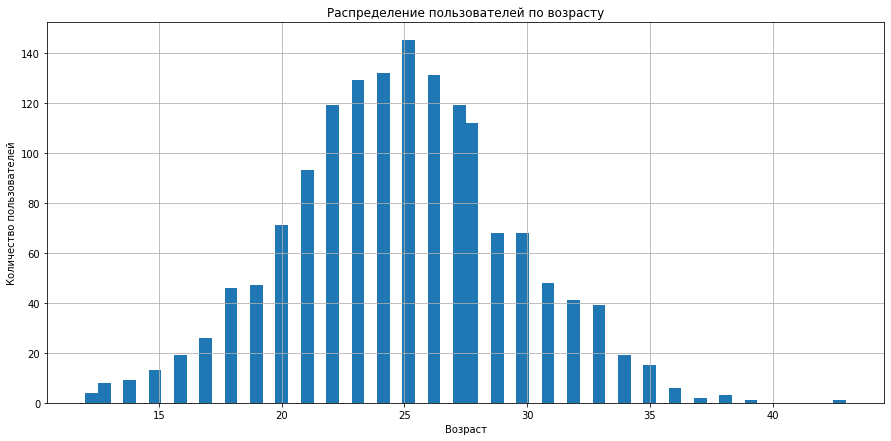

In [26]:
#визуализируем распределение данных
users.age.hist(bins=60, figsize=(15, 7))
plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

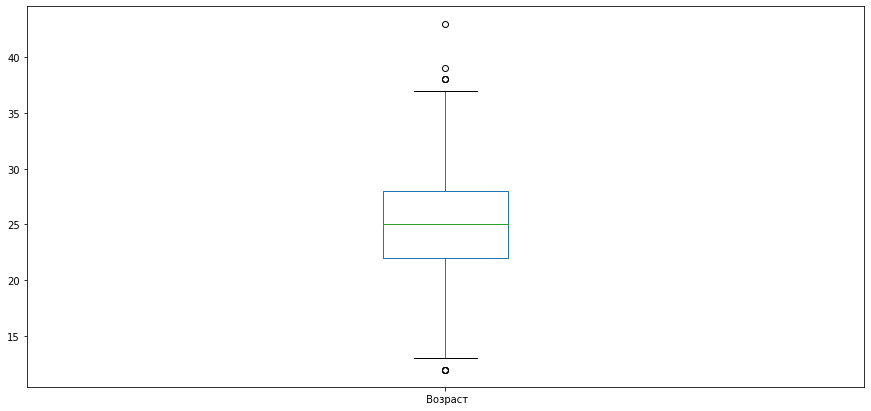

In [27]:
#визуализируем выбросы
users.age.plot.box(figsize=(15, 7), label=' Возраст');

In [28]:
users.age.describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

- Законодательно нет возрастных ограничений на пользование самокатом, поэтому значения до 18 лет допустимы.
- Самокатным сервисом пользуется в абсолютном большинстве молодежь - люди от 14 до 35 лет.
- Возраст от 22 до 28 является преобладающим с пиком в 25 лет, что является ожидаемым, так как в основном относительно новым способом перемещения по городу пользуются более молодые люди. 

### Расстояние и продолжительность поездки

In [29]:
#рассчитаем среднюю скорость поездки в кч/ч
rides['avr_speed'] = round((rides['distance'] / rides['duration']) * 0.06, 2)
rides['avr_speed']

0        10.34
1         9.93
2         7.26
3         8.73
4         9.20
         ...  
18063    11.44
18064     7.96
18065    12.45
18066    10.44
18067     8.95
Name: avr_speed, Length: 18068, dtype: float64

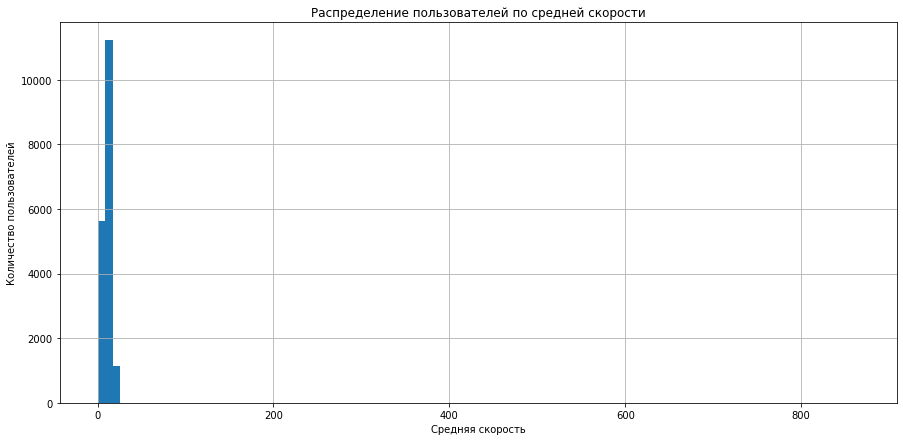

In [30]:
rides['avr_speed'].hist(bins=100, figsize=(15, 7));
plt.title('Распределение пользователей по средней скорости')
plt.xlabel('Средняя скорость')
plt.ylabel('Количество пользователей')
plt.show()

На гистаграмме видно, что существуют аномально большие значения, скорее всего связанные с делением расстояния на близкое к 0 время. Рассмотрим значения меньше 1 минут.

In [31]:
mask = rides.loc[rides['duration'] < 1]
mask

,user_id,distance,duration,date,month,avr_speed
6531,701,4196.445201,0.5,2021-08-31,8,503.57
6570,704,4830.824371,0.5,2021-10-14,10,579.70
6680,712,4684.004397,0.5,2021-03-04,3,562.08
6695,713,5215.642710,0.5,2021-02-25,2,625.88
6768,718,5197.436649,0.5,2021-02-11,2,623.69
...,...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1,663.76
17242,1477,6724.932981,0.5,2021-01-12,1,806.99
17314,1483,4445.481070,0.5,2021-03-06,3,533.46
17505,1496,5722.551787,0.5,2021-02-14,2,686.71


Эти данные из датасета не удаляем, поскольку оплата за использование самокатов была получена (что лучше проверить), а значит нужно учесть данную информацию при проверке гипотез, чтобы отсутствие данных не привело к искажению результата, при этом необходима дополнительная проверка системы расчета расстояния и продолжительности поездки из-за нереалистичных значений. 

Выведем гистаграмму без учета этих значений:

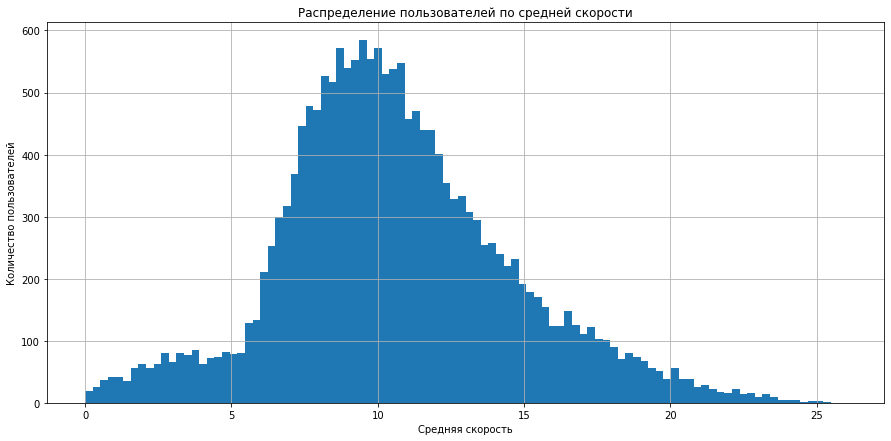

In [32]:
rides['avr_speed'].hist(bins=100, figsize=(15, 7), range=(0, 26))
plt.title('Распределение пользователей по средней скорости')
plt.xlabel('Средняя скорость')
plt.ylabel('Количество пользователей')
plt.show()

Скорость в 25 км/ч и больше реалистичное значение, ограничение на скорость в 25 км/ч было принято только в март 2023 года.

Самокатом обычно пользуются в качестве средства передвижения для экономии времени и быстроты перемещения, поэтому значения меньше меньше 3-5 км/ч (средняя скорость пешехода) могут быть связаны с некими проблемами в пользовании самокатом. Возможные причины:
- сложности в начале пользования самокатом из-за неопытности или неумения
- использование самоката не для быстрого перемещения, а для прогулки или развлечения
- возникновение проблем во время перещения, например, перекрытая дорога, многолюдная дорога и т.п.

Посмотрим на значения около 1 км/ч. 

In [33]:
#выведем строчки с низкой средней скоростью
rides.loc[rides['avr_speed'] < 1, ['distance', 'duration', 'avr_speed']]

,distance,duration,avr_speed
6611,28.793204,14.143966,0.12
6691,23.963062,2.053251,0.70
6699,195.694445,12.559127,0.93
6794,193.383776,12.773535,0.91
6816,62.568138,7.178766,0.52
...,...,...,...
17760,75.573191,5.174400,0.88
17808,180.812768,11.493126,0.94
17856,106.417577,9.304050,0.69
17881,217.943366,14.435887,0.91


Такие данные указывают на проблемы при пользовании самокатом, поскольку были преодолены слишком короткие дистанции за длительное время. Такие расчеты могут привести к недовольству пользователей и их отказу от сервиса, поэтому необходимо выяснить в чем проблема: в расчете расстояния или в самом самокате.

In [34]:
#создадим копию исходного датасета для удаления из него значений, сопряженных с проблемами и оценки реалистичных значений
rides_copy = rides.copy()

In [35]:
#удалим из копии нереалистичные значения
rides_copy = rides_copy.drop(rides_copy.loc[rides_copy['avr_speed'] < 1].index)
rides_copy = rides_copy.drop(rides_copy.loc[rides_copy['duration'] < 1].index)

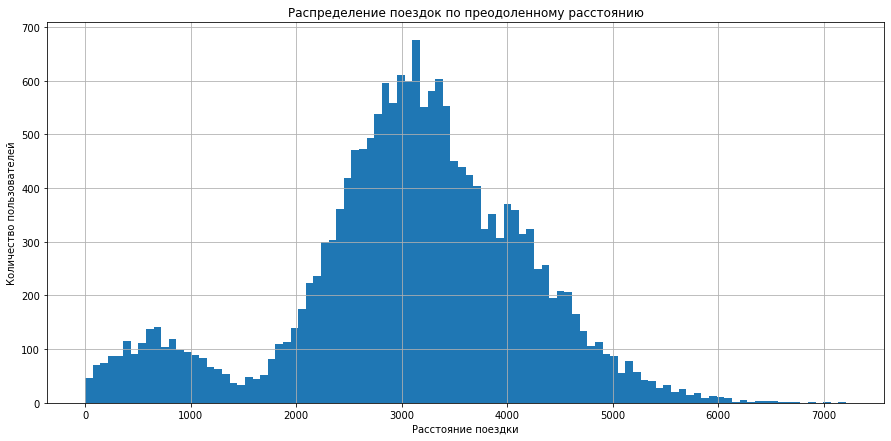

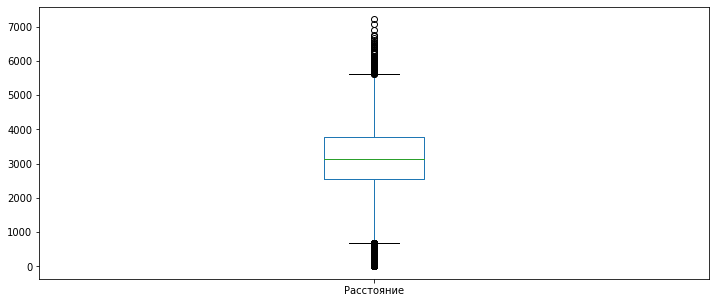

In [36]:
rides.distance.hist(bins=100, figsize=(15, 7))
plt.title('Распределение поездок по преодоленному расстоянию')
plt.xlabel('Расстояние поездки')
plt.ylabel('Количество пользователей')
plt.show()
rides['distance'].plot.box(figsize=(12, 5), label='Расстояние');

In [37]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

В качестве выбросов выделились значения больше 5 км, однако, самокат вполне могли использовать для перемещения на большие дистанции, 7 км не является аномальным расстоянием. 

Более неоднозначные значения - короткие дистанции, которые можно быстро преодолеть пешком. Расстояние в 100-300 метров может указывать на неудобство самоката или проблемы с ним. При этом на гистаграмме мы видим небольшой пик на значении 500 метров. Возможно, он возник в связи с частой необходимостью быстрого перемещения на короткие дистанции. 

Выделим поездки на короткие дистанции и поездки с маленькой средней скоростью.

In [38]:
rides_copy.loc[(rides_copy['distance'] < 300), ['distance', 'duration', 'avr_speed']]

,distance,duration,avr_speed
1213,244.210438,9.861919,1.49
2656,280.964769,10.053618,1.68
5952,266.123499,3.760353,4.25
6511,288.974241,4.788112,3.62
6573,273.668337,14.965888,1.10
...,...,...,...
17895,250.381191,10.577803,1.42
17951,134.078586,5.502795,1.46
17965,182.743404,3.730974,2.94
17989,133.534786,5.267070,1.52


In [39]:
#удалим выбросы
rides_copy = rides_copy.drop(rides_copy.loc[rides_copy['distance'] < 300].index)

В среднем пешком человек проходит 500 метров за 6 минут, на самокате эта дистанция должна преодолеваться быстрее, если также учитывать время необходимое для привыкание к самокату, в среднем скорость должна получаться больше 3 км/ч, иначе поездка получается слишком долгой для такого такого короткого расстояния. 

In [40]:
rides_copy.loc[(rides_copy['distance'] < 500) & (rides_copy['avr_speed'] < 3), ['distance', 'duration', 'avr_speed']]
#(rides_copy['duration'] > 10)

,distance,duration,avr_speed
228,409.829089,10.294197,2.39
463,307.532350,6.230129,2.96
1467,414.419765,13.776085,1.80
2133,362.010886,13.974605,1.55
4698,480.111718,14.600372,1.97
...,...,...,...
17910,466.522030,9.646548,2.90
17931,306.876233,9.736503,1.89
18007,450.981518,15.591699,1.74
18031,303.787850,7.792490,2.34


In [41]:
rides_copy = rides_copy.drop(rides_copy.loc[(rides_copy['distance'] < 500) & (rides_copy['avr_speed'] < 3)].index)
len(rides_copy)

17515

In [42]:
rides_copy.loc[rides_copy['avr_speed'] < 2.8, ['distance', 'duration', 'avr_speed']]
rides_copy = rides_copy.drop(rides_copy.loc[rides_copy['avr_speed'] < 2.8].index)
len(rides_copy)

17432

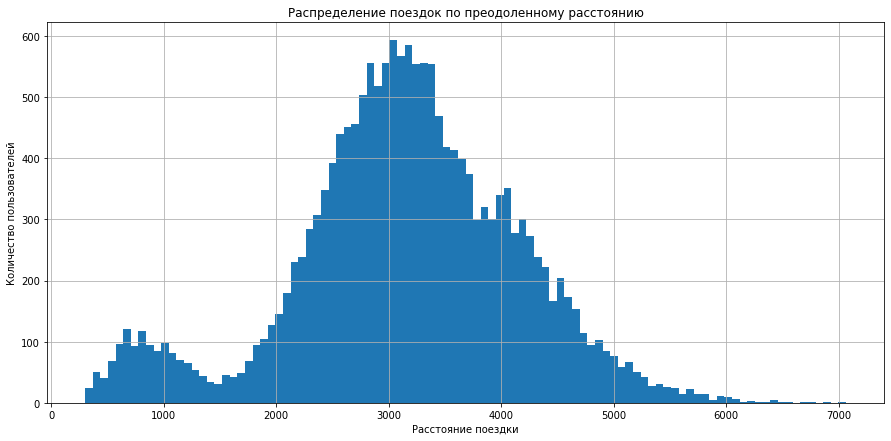

In [43]:
#оценим изменения на гистаграмме
rides_copy.distance.hist(bins=100, figsize=(15, 7));
plt.title('Распределение поездок по преодоленному расстоянию')
plt.xlabel('Расстояние поездки')
plt.ylabel('Количество пользователей')
plt.show()

После удаления выбивающихся данных небольшой пик сохранился, значит есть ряд пользователей, которые используют самокаты для коротких дистанций. Причиной может быть необходимость сэкономить время, например, быстро добраться до места при опоздании. Другой возможной причиной коротких поездок может быть неудовлетворительный сервис, в связи с которым пользователи оставляют самокат не добравшись до нужного места. 

В основном пользователи перемещаются на расстояние 2.5-3.5 км.

Рассмотрим распределение продолжительности поездки.

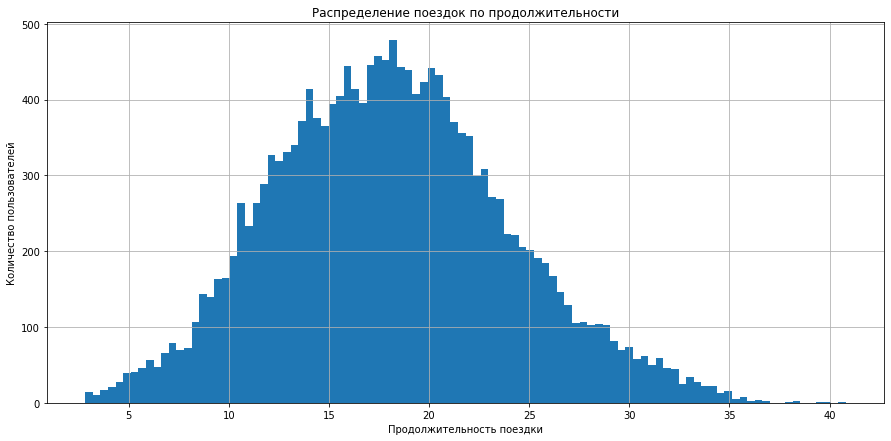

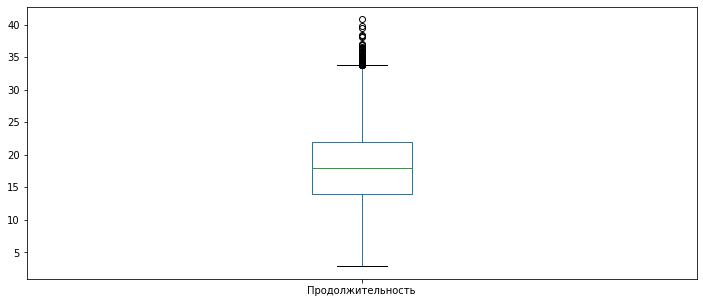

In [44]:
#выведем гистаграмму с распределением продолжительности поездки
rides_copy.duration.hist(bins=100, figsize=(15, 7))
plt.title('Распределение поездок по продолжительности')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество пользователей')
plt.show()
rides_copy['duration'].plot.box(figsize=(12, 5), label='Продолжительность');

Значения распределены нормально, выбросами были выделены значения, где поездки длились более 35 минут. Такие значения могут быть реальными, хотя и превышающими нормальное распределение, поскольку на протяжении поездки могли быть остановки в связи со светофорами, большим количеством людей на улицах, которые затрудняют движение, погодными условиями, большими расстояниями поездки.

В основном поездки занимают от 11 до 23 минут, чаще всего 18 минут.

In [45]:
rides_copy.duration.describe()

count    17432.000000
mean        18.132407
std          5.871815
min          2.824692
25%         13.946847
50%         17.928777
75%         21.891648
max         40.823963
Name: duration, dtype: float64

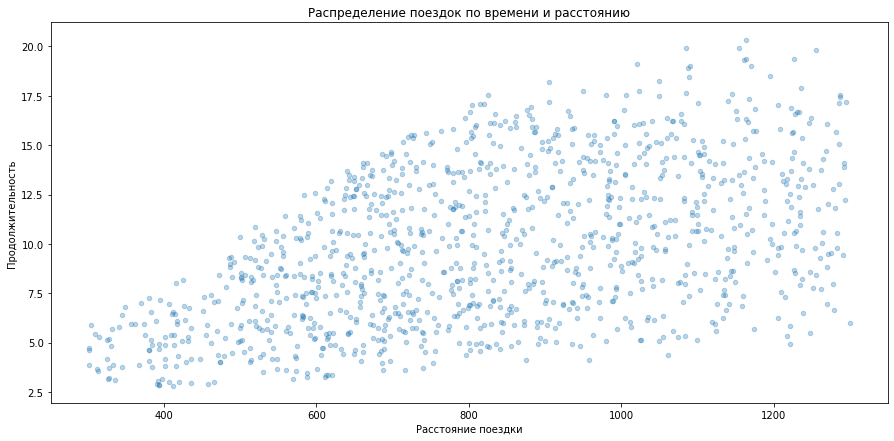

In [46]:
rides_copy.loc[rides_copy['distance'] < 1300, ['distance', 'duration']].plot(x='distance', y='duration', kind='scatter', alpha=0.3, figsize=(15, 7), xlabel='Расстояние поездки', ylabel='Продолжительность', title='Распределение поездок по времени и расстоянию');

**Выводы:**
- Пользователи развномерно распределены по выбранным городам, их доля составляет по 11-14%. Большее число пользователей находится в южных городах России.
- Количество пользователей без подписки превосходит число подписчиков, разница между двумя группами пользователей приблизительно 10%. Более значительные отличия между числом в таких городах как Пятигорск, Краснодар.
- Всех пользователей можно отнести к группе молодежь, среди пользователей преобладают люди от 21 до 28 лет.
- Перемещения всех пользователей составляет в основном 2.5-3.5 км, пик приходится на значение около 3 км, на гистаграмме отразился небольшой пик на значениях до 1 км, который может обозначать, что пользователи используют самокат для быстрого преодоления коротких дистанций или же с использованием самоката сопряжены какие-либо сложности или проблемы, в связи с которыми пользователь прекращает поездку.
- Поездки занимают от 11 до 23 минут, чаще всего 18 минут. 
- Хотя на гистаграмме с распределением расстояния поездок есть пик, на гистаграмме с продолжительностью мы не видим аналогичного пика, что означает, что данные короткие поездки могли занимать больше времени, чем могло бы потребоваться на такое расстояние. Стоит выяснить были ли данные поездки сопряжены со сложностями в управлении самокатом, проблемами, возникшими во время поездки в самокате или же на самой дороге.
- Нереалистичные данные о продолжительности поездки - слишком короткие для чрезмерно больших расстояний - необходимо проверить, поскольку они могут указывать на наличие проблем при учете расчете минут, а значит и при расчете оплаты. На возможные проблемы с самокатами также указывают долгие поездки, за которые преодоленное расстояние слишком мало (до 400 м).

<a id='fr'></a>
## Объединение данных

In [47]:
#выведем исходную размерность датасетов
print('Размерность датасета с пользователями:', users.shape)
print('Размерность датасета с поездками:', rides.shape)
print('Размерность датасета с подписками:', subscriptions.shape)

Размерность датасета с пользователями: (1534, 5)
Размерность датасета с поездками: (18068, 6)
Размерность датасета с подписками: (2, 4)


In [48]:
#объединим данные из трех датасетов
data = users.merge(subscriptions, on='subscription_type', how='outer')
data = rides.merge(data, on='user_id', how='outer')
data

,user_id,distance,duration,date,month,avr_speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,10.34,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,9.93,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,7.26,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,8.73,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,9.20,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,11.44,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,7.96,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,12.45,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,10.44,Альберт,25,Краснодар,free,8,50,0


Количество столбцов и строк совпадает с их числом в трех датасетах, проверим наличие пропусков:

In [49]:
data.isna().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
avr_speed            0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [50]:
#создадим датафрейм с данными пользователей без подписки
free = data[data['subscription_type'] == 'free']
free

,user_id,distance,duration,date,month,avr_speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,10.10,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,3.13,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,12.00,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,7.40,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,10.49,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,11.44,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,7.96,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,12.45,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,10.44,Альберт,25,Краснодар,free,8,50,0


In [51]:
#создадим датафрейм с данными пользователей с подпиской
ultra = data[data['subscription_type'] == 'ultra']
ultra

,user_id,distance,duration,date,month,avr_speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,10.34,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,9.93,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,7.26,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,8.73,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,9.20,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,9.66,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,12.42,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,12.83,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,17.83,Оксана,22,Москва,ultra,6,0,199


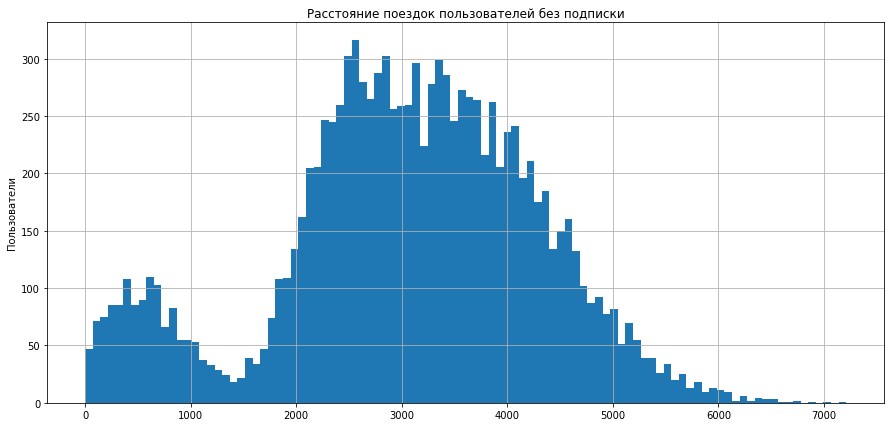

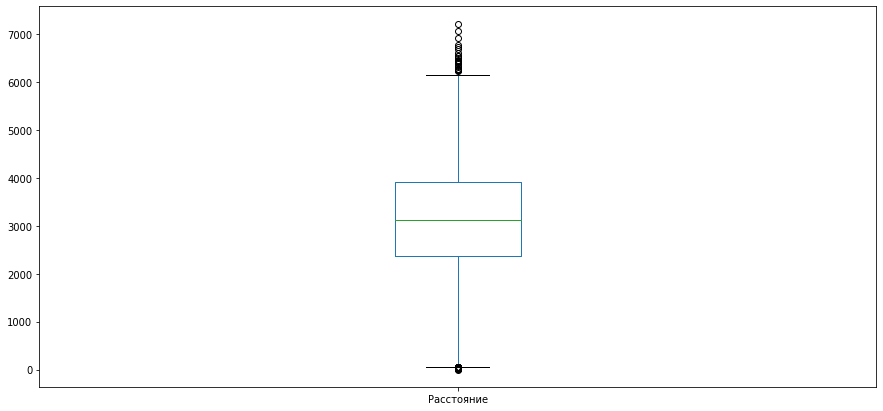

In [52]:
#визуализируем данные по поездкам без подписки 
free.distance.plot(kind='hist', bins=100, figsize=(15, 7), title='Расстояние поездок пользователей без подписки', grid=True)
plt.ylabel('Пользователи')
plt.show()
free.distance.plot.box(figsize=(15, 7), label='Расстояние');

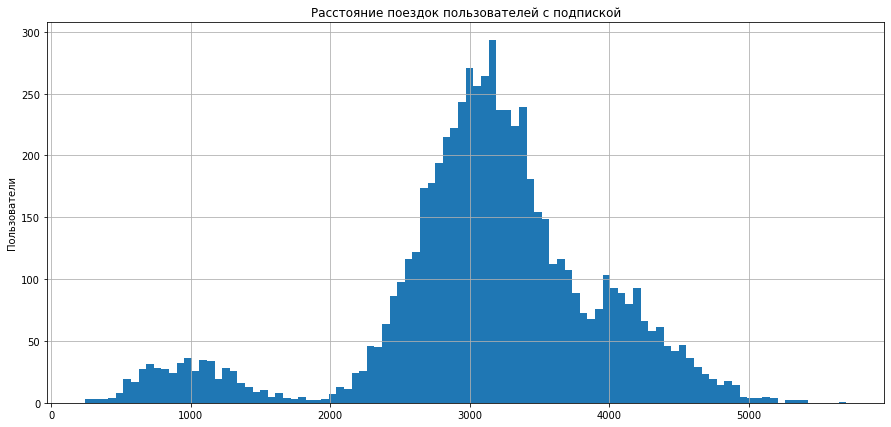

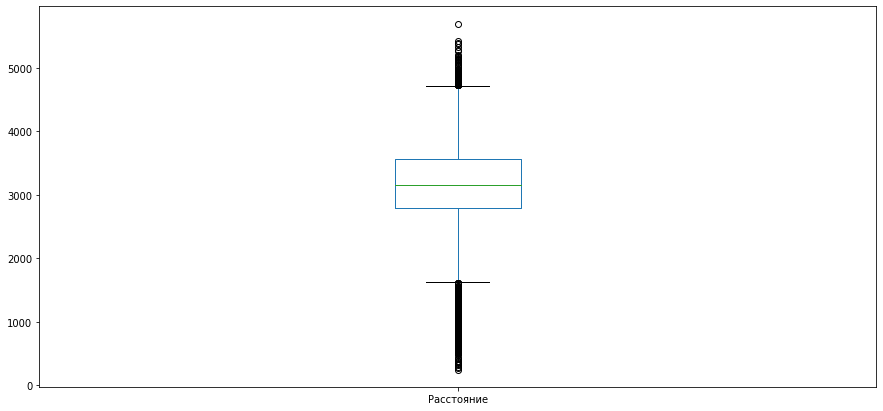

In [53]:
#визуализируем данные по поездкам c подпиской
ultra.distance.plot(kind='hist', bins=100, figsize=(15, 7), title='Расстояние поездок пользователей с подпиской', grid=True)
plt.ylabel('Пользователи')
plt.show()
ultra.distance.plot.box(figsize=(15, 7), label='Расстояние');

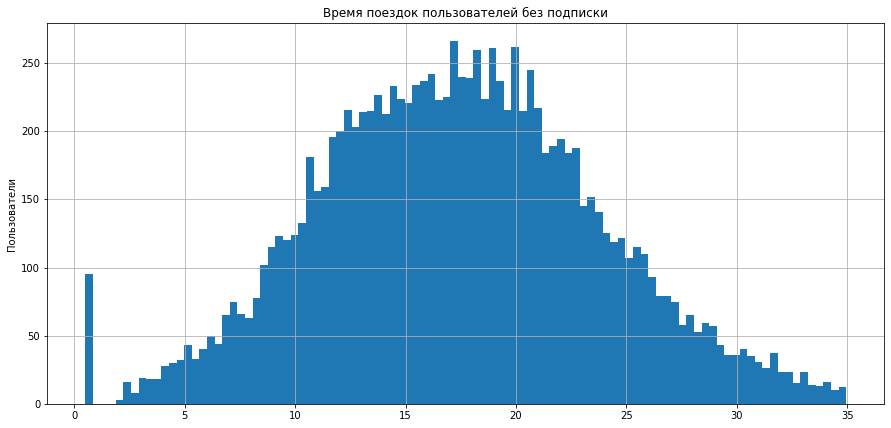

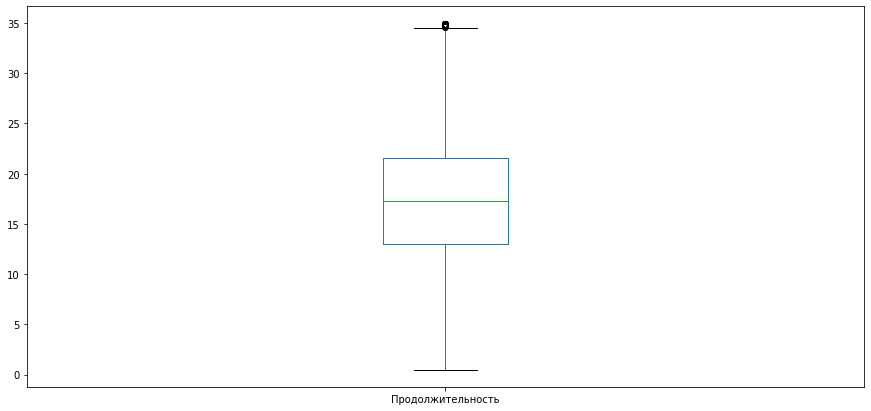

In [54]:
#визуализируем данные по поездкам без подписки
free.duration.plot(kind='hist', bins=100, figsize=(15, 7), title='Время поездок пользователей без подписки', grid=True)
plt.ylabel('Пользователи')
plt.show()
free.duration.plot.box(figsize=(15, 7), label='Продолжительность');

In [55]:
free.duration.describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

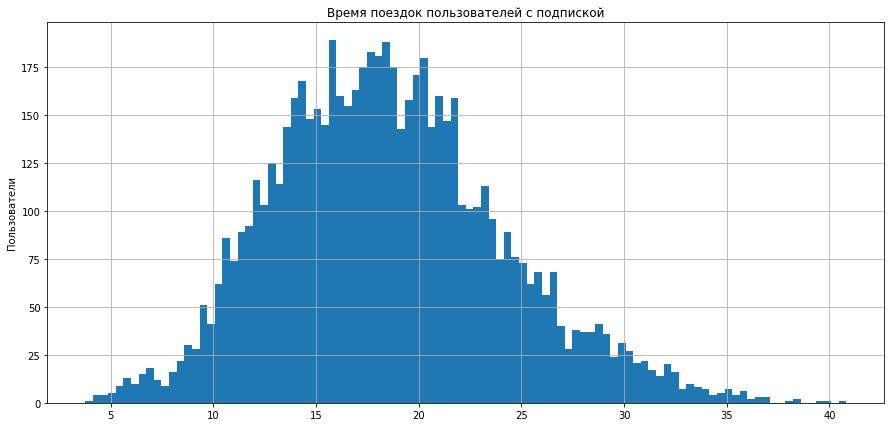

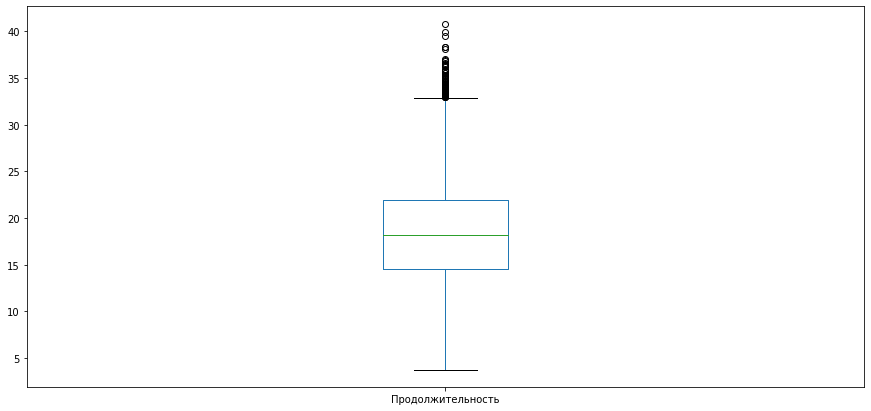

In [56]:
#визуализируем данные по поездкам c подпиской
ultra.duration.plot(kind='hist', bins=100, figsize=(15, 7), title='Время поездок пользователей с подпиской', grid=True)
plt.ylabel('Пользователи')
plt.show()
ultra.duration.plot.box(figsize=(15, 7), label='Продолжительность');

In [57]:
ultra.duration.describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

**Вывод:**
- Были объединены данные по пользователям и их поездкам. Было создано два новых датафрейма - с данными о пользователях с подпиской и без.
- В среднем время поездки по подписке больше, чем время, которое затрачивается пользователями без подписки (интервал составляет от 2.8 минут до 35 минут бесплатно и от 4 минут до 40 минут по подписке), хотя разница между показателями около минуты. В основном поездки обоих видов пользователей занимают от 13 до 22 минут. 
- Бóльшие отличия существуют между расстояниями, которые пользователи проезжают по подписке и без. Гистаграмма поездок пользователей без подписки более широкая - она делится на две части: поездок на короткие дистанции (около 1 км), и, что соответствует большинству, поездок на более дальние расстояния - от 1,5 км, наиболее частотные значения распределены относительно равномерно между значениями от 2.5 до 3.5 км. Гистаграмма поездок пользователей с подпиской более узкая, в ней также встречается небольшой подъем соответствующий коротким поездкам, но в основном расстояние поездок от 2 км. Выделен более явный пик на значении около 3.2 км. 
- По подписке проезжают меньшие расстояния, но за большее число минут, то есть поездки более спокойные, с меньшей средней скоростью. 

<a id='fi'></a>
## Подсчёт выручки

In [58]:
#округлим до целых чисел в большую сторону, так как оплата осуществляется за минуту, даже если она полностью не прошла
data['duration'] = np.ceil(data['duration'])

In [59]:
agg_data = data.groupby(['user_id', 'month']).agg({'name': 'count', 'distance': 'sum', 'duration':'sum'}).rename(columns={'name':'count'})
agg_data

count      distance  duration
user_id month                               
1       1          2   7027.511294      42.0
        4          1    754.159807       7.0
        8          2   6723.470560      46.0
        10         2   5809.911100      32.0
        11         3   7003.499363      56.0
...              ...           ...       ...
1534    6          2   3409.468534      26.0
        8          2   7622.453034      48.0
        9          1   4928.173852      23.0
        11         4  13350.015305      78.0
        12         1   2371.711192      16.0

[11331 rows x 3 columns]

In [60]:
agg_data.reset_index(inplace=True)
agg_data = agg_data.merge(data[['user_id', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']], on='user_id', how='left').drop_duplicates()
agg_data

,user_id,month,count,distance,duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,ultra,6,0,199
12,1,4,1,754.159807,7.0,ultra,6,0,199
24,1,8,2,6723.470560,46.0,ultra,6,0,199
36,1,10,2,5809.911100,32.0,ultra,6,0,199
48,1,11,3,7003.499363,56.0,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...
143446,1534,6,2,3409.468534,26.0,free,8,50,0
143459,1534,8,2,7622.453034,48.0,free,8,50,0
143472,1534,9,1,4928.173852,23.0,free,8,50,0
143485,1534,11,4,13350.015305,78.0,free,8,50,0


In [61]:
def money(row):
    a = (row['duration']*row['minute_price']) + row['subscription_fee'] + (row['start_ride_price'] * row['count'])
    return a

In [62]:
agg_data['money'] = agg_data.apply(money, axis=1)
agg_data

,user_id,month,count,distance,duration,subscription_type,minute_price,start_ride_price,subscription_fee,money
0,1,1,2,7027.511294,42.0,ultra,6,0,199,451.0
12,1,4,1,754.159807,7.0,ultra,6,0,199,241.0
24,1,8,2,6723.470560,46.0,ultra,6,0,199,475.0
36,1,10,2,5809.911100,32.0,ultra,6,0,199,391.0
48,1,11,3,7003.499363,56.0,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...
143446,1534,6,2,3409.468534,26.0,free,8,50,0,308.0
143459,1534,8,2,7622.453034,48.0,free,8,50,0,484.0
143472,1534,9,1,4928.173852,23.0,free,8,50,0,234.0
143485,1534,11,4,13350.015305,78.0,free,8,50,0,824.0


**Вывод**

Были сгруппированы данные по месяцам и по каждому пользователю для подсчета помесячной выручки с каждого клиента в зависимости от наличия или отсутствия подписки. 

<a id='six'></a>
## Проверка гипотез

*Вопрос:* Тратят ли пользователи с подпиской больше времени на поездки?

**H0:** Пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки

**H1:** Пользователи с подпиской тратят больше времени на поездки

In [63]:
alpha = 0.05

results = st.ttest_ind(ultra['duration'], free['duration'], alternative='greater')

print('p_value равен: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p_value равен:  1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Вывод:**
Нулевая гипотеза отвергнута в пользу альтернативной, а значит предположение о том, что пользователи с подпиской тратят больше времени на поездки является вероятным. 

*Вопрос:* Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

**H0:** Среднее расстояние, которое проезжают пользователи с подпиской равно 3130 метров

**H1:** Среднее расстояние, которое проезжают пользователи с подпиской больше 3130 метров

In [64]:
optimal_value = 3130

results = st.ttest_1samp(ultra['distance'], optimal_value, alternative='greater')
#results = st.ttest_1samp(ultra['distance'], optimal_value)

print('p_value равен: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p_value равен:  0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Вывод:**
Гипотезу не удалось отвергнуть, что означается, что пользователь в среднем проезжает равное оптимальному с точки зрения износа расстоянию. Так, можно сделать вывод о том, что ранее обсуждаемые проблемы с самокатами возникали в большинстве случаев не из-за их износа. 


*Вопрос:* Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки. 

**H0:** Помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки

**H1:** Помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки

In [65]:
ultra_money = agg_data.loc[agg_data['subscription_type'] == 'ultra', 'money']
free_money = agg_data.loc[agg_data['subscription_type'] == 'free', 'money']

results = st.ttest_ind(ultra_money, free_money, alternative='greater')

print('p_value равен: ',  results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')

p_value равен:  1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Вывод:**
Нулевая гипотеза была отвергнута в пользу альтернативной - пользователи с подпиской тратят в месяц больше, чем пользователи без подписки. Таким образом, сервису для увеличения общей выручки необходимо увеличить число подписчиков, поэтому проведение акций будет являться хорошим способом дальнейшего увеличения прибыли.  

*Вопрос:* Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:**
Необходимо рассмотреть зависимые данные: парные выборки до внесения изменений в систему и после, в таком случае мы пользуемся методом scipy.stats.ttest_rel и проверяем гипотезу о равенстве среднего значения генеральной совокупности до и после обновления мобильного приложения. Проверям одностороннюю гипотезу и используем параметр `alternative = 'less'`


**H0:** Количество обращений в техподдержку после обновления приложения равно количеству обращений до обновления.

**H1:** Количество обращений в техподдержку после обновления меньше, чем количество обращений до.

<a id='sev'></a>
## Общий вывод

*Предобработка данных*
- В данных из трех датасетов практически не были обнаружены ошибки: были удалены дубликаты, а также исправлен тип данных для работы с информацией по дате. Для получения ответа по гипотезам был создан столбец с обозначением месяца, объединены таблицы с информацией о пользователях и их поездках, посчитана помесячная выручка по каждому из клиентов. 
- В ходе исследовательского анализа были выявлены нереалистичные значения: близкие к 0 данные по длительности поездки, а также поездки с небольшой средней скоростью, на очень короткие дистанции за длительный срок. Они могут означать наличие ошибок или сбоев в системе подсчета времени, что может сказаться на оплате, а также указывают на возможные проблемы при использовании самокатов, в связи с небольшими расстояниями поездок. 

*Выводы по гипотезам:*
- Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. 
- Помесячная выручка от пользователей с подпиской больше, чем от пользователи без подписки.

Таким образом, для увеличения общей выручки необходимо увеличить число подписчиков, поскольку они тратят больше времени и средств, что оправдывает необходимость проведения акций для побуждения большего числа пользователей обрести подписку. 

- Среднее расстояние поездок в среднем равно оптимальному значению износа самоката, что подводит к выводу о том, что проблема с самокатами, на которую указывает исследовательский анализ возникла по другой причине нежели износ. 

*Рекомендации:*
- Провести дополнительное исследование на базе нереалистичных данных для выявления, существует ли проблемы или неисправности в самокатах.
- Данные о расстоянии и продолжительности поездок указывают на наличие относительно долгих, но на короткие дистанции поездок, что может быть связано со сложностями при управлении самокатом или возникновением технических проблем. Для улучшения качества сервиса можно отправлять пользователю опрос для выяснения причин перемещения на короткие расстояния (например, до 400 метров) или уточнения, доволен ли клиент сервисом и возникла ли какая-либо трудность, а также отображать в мобильном приложении инструкцию по пользованию самокатом, если такой нет.
- Доля пользователей с подпиской в различных городах разная - в Москве и Омске доля пользователей с подпиской и без практически одинакова, тогда как в других горадах отличия более значительные. При проведении локальных акций по городам можно в первую очередь проводить их в городах на юге России, поскольку число пользователей там больше, а также и доля пользователей без подписки.
- Проверить систему подсчета времени на сбои и ошибки. 
- Ввести регламент проверки самоката на технические проблемы, если несколько поездкок подряд на нем прекращались после преодоления коротких расстоний. 